In [2]:
import pandas as pd
import numpy as np
import re
from itertools import product
import itertools
import matplotlib.pyplot as plt

## Hsiao published fatty acid(FA) distribution

In [3]:
hsiao = pd.read_csv('/home/karnet/Downloads/Hsiao1991/PL_all.csv',skiprows=0)
hsiao['Value1'] = hsiao['Purified parasites'].apply(lambda x: float(x.split(' + ')[0]))
hsiao_dict = dict(zip(hsiao['Unnamed: 0'],hsiao['Value1']))
hsiao_dict

{'C14:0': 0.87,
 'C16:0': 32.32,
 'C16:1': 2.14,
 'C17:0': 0.42,
 'C16:2': 0.64,
 'C18:0': 13.27,
 'C18:1': 24.82,
 'C18:2': 12.33,
 'C20:0': 0.69,
 'C18:3': 0.74,
 'C20:2': 0.18,
 'C22:0': 1.16,
 'C20:4': 6.21,
 'C20:5': 0.92,
 'C24:0': 0.07,
 'C24:1': 0.9,
 'C22:5': 0.65,
 'C22:6': 1.43}

## Alex Maier Dataset

### Preprocessing of data

In [4]:
# load dataset
df_alex = pd.read_excel('RBC and asexual Pf lipidome.xlsx', skiprows=1)
# drop rows with only NaN values
df_alex.dropna(axis=0, how='all', inplace=True)
df_alex.reset_index(drop=True, inplace=True)

lst = df_alex.iloc[:,0]
index_classes = [0]
head_group_nme = []
# Find all different lipid groups in file
for i,x in enumerate(lst):
    if i == len(lst)-1:
        break
    if x[:2] != lst[i+1][:2]:
        index_classes.append(i+1)
        if i < 128:
            head_group_nme.append(x.split(' ')[0])

df_alex.set_index('Unnamed: 0', inplace=True)
'''
Calcuate mean and std. for each metabolite in each phase mean = mean(Ring1,Ring2,Ring3) 
In addition produce dict with
key = metaboliteID, 
value as nested list each entry for a phase = [[Ring_phase],[Tropho_Phase],[Schizont_Phase]]
'''
# get each metabolite in every phase
dic = {}
nrow = 134
for i in range(4):
    phase = df_alex.columns[i*3][:-1]
    print(phase)
    data = df_alex.iloc[:,i*3:i*3+3].T
    df_alex['mean_'+phase] = df_alex.iloc[:nrow,i*3:i*3+3].mean(axis=1)
    df_alex['std_'+phase] = df_alex.iloc[:nrow,i*3:i*3+3].std(axis=1)
    df_alex['coeff_var'+phase] = df_alex['std_'+phase] / df_alex['mean_'+phase]
        

RBC
Ring 
Trophozoite 
Schizont 


In [5]:
def SLIMEr_writer(name:str) -> str:
    edukt = name
    name = name.replace('(','').replace(')','')
    name = name.replace('_', ' ')
    name = name.replace(' ',' + 1 ')
    product = '1 '+ name
    return edukt +  ' -> ' + product

In [6]:
df_alex['SLIMEr'] = df_alex.index.map(SLIMEr_writer) 
df_alex['SLIMEr']

Unnamed: 0
CE 16:0                                           CE 16:0 -> 1 CE + 1 16:0
CE 16:1                                           CE 16:1 -> 1 CE + 1 16:1
CE 18:1                                           CE 18:1 -> 1 CE + 1 18:1
CE 18:2                                           CE 18:2 -> 1 CE + 1 18:2
CE 18:3                                           CE 18:3 -> 1 CE + 1 18:3
                                               ...                        
% TAG                                                 % TAG -> 1 % + 1 TAG
Sphingolipids (total)    Sphingolipids (total) -> 1 Sphingolipids + 1 t...
% Cer                                                 % Cer -> 1 % + 1 Cer
% DHSM                                              % DHSM -> 1 % + 1 DHSM
% SM                                                    % SM -> 1 % + 1 SM
Name: SLIMEr, Length: 151, dtype: object

### Produce DataFrames for each **head** group and calculate its mean mass per stage, can be used for the backbone part of SLIMEr (2a) or $S_B$

In [7]:
# Define a function to sum positive values
def sum_positive(series):
    return sum(value for value in series if value > 0)

head_group_dic = {}
# Loop to go separately through all the different lipid head group classes
for step in range(len(index_classes)):
    if index_classes[step] == 118: 
        break
    # get slice with only specific headgroup 
    df = df_alex.iloc[index_classes[step]:index_classes[step+1]].copy()
    # get slice with mean, std, covariance calculation
    #analysis_df_part = df.iloc[:,-:]
    # slice with only the mean value calculation
    df_means = df[['mean_RBC','mean_Ring ','mean_Trophozoite ','mean_Schizont ']].T
    df_means = df_means.sub(df_means.iloc[0], axis=1)
    
    # get total mean mass of head group per stage
    col_sum = df_means.apply(sum_positive, axis=1)
    head_group_dic[head_group_nme[step]] = col_sum
    # calculation of contribution of each specific lipid to its head group
    df_means = df_means.apply(lambda x: x/col_sum)
    df_means['Sum nmol']= col_sum
    #print(df_means)

# Produce strings with the correct stoichiometric values for each head group lipid in the data set
str_lst = ['','','']
for head_group in head_group_dic:
    addition = ' + '
    for i,stage_str in enumerate(str_lst):
        value = head_group_dic[head_group][i+1]-head_group_dic[head_group][0]
        
        value = value #* stage_factor_vec[i+1]
# no value if too small or negativ
        if value.round(7) > 0:
            stage_str = addition + str(value.round(7))+' '+head_group
            str_lst[i]+=stage_str

str_lst = [x[3:] for x in str_lst]         
for value_str in str_lst:
    # Split the string into individual values
    values = value_str.split(' + ')

    # Calculate the sum of the values
    sum_of_values = sum(float(value.split()[0]) for value in values)

    print(sum_of_values)
# values in nmol Head/10⁹ cells
str_lst


182.44666660000001
1428.8200000999998
3038.84


['12.2366667 DAG + 77.2833333 PC + 75.8466667 PE + 2.6333333 PG + 7.0333333 PS + 7.2133333 TAG + 0.1933333 Cer + 0.0066667 SM',
 '0.21 CE + 123.9522222 DAG + 167.8877778 FreeChol + 629.9655556 PC + 324.9555556 PE + 32.1066667 PG + 90.9511111 PS + 35.1888889 TAG + 2.4633333 Cer + 1.0555556 DHSM + 20.0833333 SM',
 '329.83 DAG + 136.39 FreeChol + 1576.2333333 PC + 607.5966667 PE + 101.1633333 PG + 107.4766667 PS + 174.81 TAG + 1.54 Cer + 2.53 DHSM + 1.27 SM']

In [8]:
slimeR_2_a = pd.DataFrame(head_group_dic).T
print(slimeR_2_a.columns)
slimeR_2_a = slimeR_2_a.T-slimeR_2_a['mean_RBC'].values
slimeR_2_a = slimeR_2_a.drop(index='mean_RBC')
slimeR_2_a = slimeR_2_a.T
slimeR_2_a['reaction'] = ['2a']*len(slimeR_2_a)
slimeR_2_a.T

Index(['mean_RBC', 'mean_Ring ', 'mean_Trophozoite ', 'mean_Schizont '], dtype='object')


,CE,DAG,FreeChol,LPC,PC,PE,PG,PS,TAG,Cer,DHSM,SM
mean_Ring,0.0,12.236667,0.0,0.0,77.283333,75.846667,2.633333,7.033333,7.213333,0.193333,0.0,0.006667
mean_Trophozoite,0.21,123.952222,167.887778,0.0,629.965556,324.955556,32.106667,90.951111,35.188889,2.463333,1.055556,20.083333
mean_Schizont,0.0,329.83,136.39,0.0,1576.233333,607.596667,101.163333,107.476667,174.81,1.54,2.53,1.27
reaction,2a,2a,2a,2a,2a,2a,2a,2a,2a,2a,2a,2a


In [9]:
slimeR_2_a.T.columns
color_dict = {
    'CE': 'blue',
    'DAG': 'green',
    'FreeChol': 'orange',
    'LPC': 'purple',
    'PC': 'red',
    'PE': 'cyan',
    'PG': 'brown',
    'PS': 'pink',
    'TAG': 'gray',
    'Cer': 'magenta',
    'DHSM': 'lime',
    'SM': 'teal'
}
[color_dict[p] for p in slimeR_2_a.T]

['blue',
 'green',
 'orange',
 'purple',
 'red',
 'cyan',
 'brown',
 'pink',
 'gray',
 'magenta',
 'lime',
 'teal']

### Pie chart of head group distribution

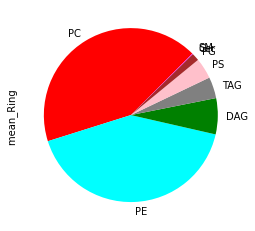

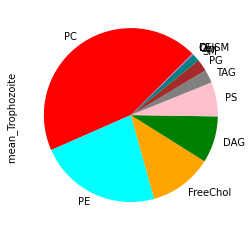

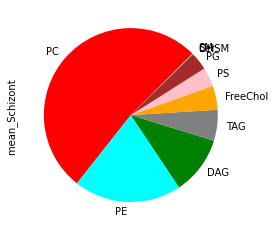

In [10]:
# Make pie charts of head group dict
for col in slimeR_2_a.columns:
    if 'mean' in col:
        mean_s = slimeR_2_a[col][slimeR_2_a[col]>0].sort_values(ascending=False)
        mean_s.plot(kind='pie', labels=mean_s.index,colors= [color_dict[p] for p in mean_s.index], startangle=45)
        plt.show()

## Side chain calculations

In [11]:
def count_pattern_in_text(text_lst, pattern):
    '''
    Function to count pattern occurence in string 
    here iterated through string list as dfs column list used 
    '''
    # List to store counts
    count_list = []
    # Count how often the pattern appears in each string
    for string in text_lst:
        count = len(re.findall(pattern, string))
        count_list.append(count)
    return count_list
# Define a function to sum positive values
def sum_positive(series):
    return sum(value for value in series if value > 0)

side_chain_dic = {}
df_absolut = df_alex.iloc[:118].copy()

strings = df_absolut.index
# Find all occurrences of "any:number" pattern in each string
matches = [re.findall(r'\d+:\d+', s) for s in strings]

# Flatten the list of matches
flat_matches = [match for sublist in matches for match in sublist]

# Get sorted unique strings (side chains)
unique_strings = sorted(set(flat_matches))

# loop through unique side chains as patterns
for pattern in sorted(unique_strings):
    # Special case because Cer or SM have 18:0 in their backbone
    # Cer 15:0 -> Cer + 18:0 + 15:0
    if pattern=='18:0':
        pattern = r'^(SM|Cer)|18:0'
    # Use str.contains() with the pattern to filter index
    mask = df_absolut.index.str.contains(pattern)
    filtered_values = df_absolut[mask]
    # get slice with only mean values
    filtered_values = filtered_values[['mean_RBC','mean_Ring ','mean_Trophozoite ','mean_Schizont ']].T
    filtered_values = filtered_values.sub(filtered_values.iloc[0], axis=1)
    # Count occurence of pattern in name and multiply for correct molar representation DAG (32:0) 16:0_16:0 means two 16:0
    filtered_values =  filtered_values*count_pattern_in_text(filtered_values.columns, pattern)
    # Calculate sum of means of specific lipid for each stage
    col_sum = filtered_values.apply(sum_positive,axis=1)
    # Calculate distribution of each lipids subspecies
    #df_means = df_means.apply(lambda x: x/col_sum)
    # Display pattern and corresponding filtered v['mean_RBC','mean_Ring ','mean_Trophozoite ','mean_Schizont ']
    print(pattern)
    print(filtered_values.T)
    print(col_sum)
    if pattern == r'^(SM|Cer)|18:0':
        pattern = '18:0'
    side_chain_dic[pattern]=col_sum

14:0
            mean_RBC  mean_Ring   mean_Trophozoite   mean_Schizont 
Unnamed: 0                                                         
SM 14:0          0.0   -1.173333          -0.322222       -0.843333
mean_RBC             0
mean_Ring            0
mean_Trophozoite     0
mean_Schizont        0
dtype: int64
15:0
            mean_RBC  mean_Ring   mean_Trophozoite   mean_Schizont 
Unnamed: 0                                                         
SM 15:0          0.0       -0.45           0.021111           -0.25
mean_RBC             0.000000
mean_Ring            0.000000
mean_Trophozoite     0.021111
mean_Schizont        0.000000
dtype: float64
16:0
                      mean_RBC  mean_Ring   mean_Trophozoite   mean_Schizont 
Unnamed: 0                                                                   
CE 16:0                    0.0   -3.046667           0.210000       -2.863333
DAG (32:0) 16:0_16:0       0.0    0.000000          55.591111       74.293333
DAG (34:0) 16:0_18:0     

/tmp/ipykernel_4137706/4227784519.py:37: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  mask = df_absolut.index.str.contains(pattern)


In [12]:
def find_combinations(numbers:list, targets:list, indi_num:tuple=(1,4))->list[tuple]:
    result = []
    print(targets)
    # loop to test all different permutations starting with one value to three
    for r in range(indi_num[0], indi_num[1]):
        # produces every possible permutation with repeating nuumbers 
        for combination in product(numbers, repeat=r):
            if sum(combination) in targets:
                result.append(combination)
    return result


def calc_frequency(values:list):
    flat_vals = values
    if not all(isinstance(x, int) for x in values):
        flat_vals = [val for vals in values for val in vals]
    
    frequency = {}
    for value in flat_vals:
        frequency[value] = frequency.get(value, 0) + 1
    frequency = {k: v/sum(frequency.values()) for k,v in frequency.items()}
    return frequency

# Produce strings with the correct stoichiometric values for each side chain fatty acid in the data set
str_lst = ['','','']

for side_chain in sorted(side_chain_dic):
    addition = ' + '
    try:
        #print(find_combinations(side_chains,[int(side_chain[:-2])]))
        pass
    except ValueError:
        continue
    for i,stage_str in enumerate(str_lst):
        value = side_chain_dic[side_chain][i+1]-side_chain_dic[side_chain][0]
        value = value
        if value.round(7) > 0:
            stage_str = addition + str(value.round(7))+' '+side_chain
            str_lst[i]+=stage_str

str_lst = [x[3:] for x in str_lst]    

for value_str in str_lst:
    # Split the string into individual values
    values = value_str.split(' + ')
    # Calculate the sum of the values
    sum_of_values = sum(float(value.split()[0]) for value in values)

    print(sum_of_values)
# value in nmol FA/10⁹ cells
# values higher than head group calculation because counts triple e.g. DAG (1.->34:1) 2.->16:0_ 3.->18:1
str_lst

212.3866667
1595.5966669000004
3767.246666799999


['2.71 16:0 + 0.2 18:0 + 27.1066667 18:1 + 0.0333333 24:1 + 0.0833333 24:2 + 0.0066667 25:0 + 8.83 32:0 + 0.92 32:1 + 1.6566667 34:0 + 73.1566667 34:1 + 9.2866667 34:2 + 1.4566667 34:3 + 20.9 36:1 + 24.8866667 36:2 + 7.89 36:3 + 10.56 36:4 + 0.2833333 36:5 + 0.5666667 38:3 + 6.34 38:4 + 5.7 38:5 + 0.0333333 38:7 + 0.6433333 40:5 + 1.5033333 40:6 + 0.42 40:7 + 1.0866667 48:0 + 4.3933333 54:6 + 1.7333333 56:6',
 '0.0211111 15:0 + 112.8133333 16:0 + 0.15 17:0 + 60.4255556 18:0 + 164.17 18:1 + 3.6 18:2 + 0.1722222 22:0 + 0.38 23:0 + 5.7777778 24:0 + 6.4555556 24:1 + 2.6222222 24:2 + 0.1266667 24:3 + 0.5566667 25:0 + 0.1488889 25:1 + 0.2133333 26:0 + 0.4111111 26:1 + 0.4322222 26:2 + 103.44 32:0 + 10.4711111 32:1 + 44.8366667 34:0 + 335.9255556 34:1 + 99.9477778 34:2 + 7.2788889 34:3 + 9.8455556 36:0 + 161.2988889 36:1 + 137.3733333 36:2 + 46.4311111 36:3 + 63.9233333 36:4 + 16.5422222 36:5 + 6.8088889 38:3 + 51.54 38:4 + 51.7611111 38:5 + 15.3666667 38:6 + 0.3066667 40:4 + 20.8266667 40:5 

In [13]:
def has_n_same_values_before_colon(element:tuple, n) -> bool:
    ''' 
    FUNCTION
    ----------------------------------------------------
        Give True or False bool for permutation element 
        if it has n-many occurence of a value e.g. (14, 14)
        BEWARE Function only used for string production
               not to calculate the frequence of side
               chain occurence
    ----------------------------------------------------
    RETURN
        BOOL
    '''
    if type(element[0])==int:
        values = list(element)
        return any(values.count(value) >= n for value in values)
    elif type(element[0])==str:
        values = [int(sub_element.split(':')[0]) for sub_element in element.split('_')]
        return any(values.count(value) == 2 for value in values)

def count_same_number_occurrences(lst):
    ''' 
    FUNCTION
    ----------------------------------------------------
        Count how often twice a number in the same element
        of permutation list occurs
        BEWARE Function only used for string production
               not to calculate the frequence of side
               chain occurence 
    ----------------------------------------------------
    RETURN
        counts : DICT(key: side chain value, 
                      value: number of double occurence in same element)
    '''
    counts = {}
    for element in lst:
        numbers = [int(sub_element.split(':')[0]) for sub_element in element.split('_')]
        for number in set(numbers):
            if numbers.count(number) == 2:
                counts[number] = counts.get(number, 0) + 1

    return counts

def filter_txt_lst(lst_text):
    ''' 
    FUNCTION
    ----------------------------------------------------
        Check string list for double occurence of 
        basically the same side chain configuration
        e.g.('16:0_18:1_18:0','16:0_18:0_18:1'), then 
        filter to exclude these.
        BEWARE Function only used for string production
               not to calculate the frequence of side
               chain occurence 
    ----------------------------------------------------
    RETURN
        list: list of side chain permutation strings used for SLIMEr
    '''
    occurrence_counts = count_same_number_occurrences(lst_text)
    not_double_lst = [element for element in lst_text if not has_n_same_values_before_colon(element, 2)]
    filtered_lst = [element for element in lst_text if has_n_same_values_before_colon(element, 2)]
    for key in occurrence_counts:
        occurrences = 0
        for element in filtered_lst:
            # only search for double number key with one unsaturation
            # this is the only possible double occurence in data
            if f'{key}:1' in element:
                    occurrences += 1
                    if occurrences == 2:
                        filtered_lst.remove(element)
                        continue
    return not_double_lst+filtered_lst

def combinations_side_chain_lst(chains:list, unsaturation:list):
    '''
    Function
    -------------------------------------------------
        Function to write list of strings of all possible chain and saturation permutations
    --------------------------------------------------
    BEWARE 
        Function only used for string production
        not to calculate the frequence of side
        chain occurence
    --------------------------------------------------
    --------------------------------------------------
    Returns
    str_ar : list of strings 
    '''
    chains =[sorted(x) for x in chains]
    chains = list(set(map(tuple, chains)))

    unsat_equal_1_bool = unsaturation ==1
    unsaturation =[sorted(x) for x in unsaturation]
    unsaturation = list(set(map(tuple, unsaturation)))

    combinations = list(itertools.product(chains, unsaturation))
    # Build object matrix with correct number of entries
    str_ar = np.empty((len(combinations), len(chains)), dtype=object)
    # Has None as default value, here changed to '' so string addition in loop works
    str_ar = np.array([['' for element in row] for row in str_ar], dtype=object)
    counter = 0
    for i, combi in enumerate(combinations):
        for j, chain in enumerate(combi[0]):
            for k, unsat in enumerate(combi[1]):
                if has_n_same_values_before_colon(combi[0], len(combi[0])):
                    counter+=1
                    if not counter%(len(combi[0]))==0:
                        continue
                str_text = (f'{chain}:{combi[1][k-j]}')
                str_ar[i, k] = str_ar[i, k] + str_text+'_'

    str_ar = np.unique(str_ar.flatten())
    str_ar = [x[:-1] for x in str_ar if not x=='']
    
    if unsat_equal_1_bool:
        return str_ar
    else:
        return filter_txt_lst(str_ar)
# Test to see if functions work
list1 = [(14, 18, 20), (14, 20, 18), (16, 16, 20), (16, 18, 18), (16, 20, 16), (18, 14, 20), (18, 16, 18), (18, 18, 16), (18, 20, 14), (20, 14, 18), (20, 16, 16), (20, 18, 14)]
list2 = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]
text = combinations_side_chain_lst(list1, list2)

## FA calculation using normal distribution for PLs without side chain annotation

In [14]:
strings = df_alex.index
# Filter for strings without values in brackets
filtered_strings = [s for s in strings if not re.search(r'\([\w\s:]+\)', s) and any(int(val) > 26 for val in re.findall(r'\b\d+\b', s))]
mask = df_absolut.index.isin(filtered_strings)
permutation = df_absolut[mask]
permutation = permutation[['mean_RBC','mean_Ring ','mean_Trophozoite ','mean_Schizont ']]
# Possible side chains
side_chains = [ 14, 16, 18, 20]
# Possible unsaturation of side chains
unsaturation = [0,1]
# Dict for each stage and list of dicts 
ring_dict = {}
troph_dict = {}
schizont_dict = {}
stoich_side_chain_lst = [ring_dict, troph_dict, schizont_dict]
name_dict = [{},{},{}]
# List that captures all rows that are not built by allowed combinations
outlayers = []

for row in permutation.index:
    print(f'Working on {row}')
    # extract int values of the index string 'PS 36:0' -> [36,0]
    value_lst = [int(val) for val in re.findall(r'\b\d+\b', row)]
    # find all possible permutations of side chains
    combis_chain = find_combinations(side_chains, [value_lst[0]])
    # print(combis_chain)
    # calculate the frequency of the side chain
    dict1 = calc_frequency(combis_chain)
    #print(dict1)
    # determine if 2 or 3 side chains possible for combinatory reasons
    chains_num = (2,3)
    if 'TAG' in row:
        chains_num = (3,4)
    # find all possible permutations of side chain unsaturation thus chains_num
    combis_desat = find_combinations(unsaturation, [value_lst[1]], chains_num)
    # calculate the frequency of the side chain unsaturation
    dict2 = calc_frequency(combis_desat)
    #print(permutation.loc[row])
    # calculate stoichiometric values for each stage for every possible side chain and unsaturation
    for i in range(1,4):
        val = (permutation.loc[row][i] - permutation.loc[row][0]) #* stage_factor_vec[i]
        if val <=0: 
            continue
        # Create string list for all possible permutation of this PL 
        # e.g. PC 32:0 -> ['PC (32:0) 14:0_18:0', 'PC (32:0) 16:0_16:0']
        string_lst = combinations_side_chain_lst(combis_chain, combis_desat)
        string_lst = [row.split(' ')[0]+' ('+row.split(' ')[1]+') '+element for element in string_lst]
        print(string_lst,i)
        # Write value in dict for each permutation val_PC 32:0/len(all possible permutation of this PL)
        # normal distribution of FA 
        for meta in string_lst:
            print(meta,val/len(string_lst), val)
            name_dict[i-1][meta] = name_dict[i-1].get(meta,val/len(string_lst))
        
        # Stoichiometric value calculation of every side chain permutation
        combined_dict = {(f'{k1}:{k2}'): chains_num[0] * v1 * v2 * val for k1, v1 in dict1.items() for k2, v2 in dict2.items()}
        if combined_dict != {}:print(combined_dict)
        
        # Capture all rows that are not built by allowed combinations
        if combined_dict =={}:
            outlayers.append(row)

        for key, value in combined_dict.items():
            stoich_side_chain_lst[i-1][key] = stoich_side_chain_lst[i-1].get(key, 0) + value
        print(stoich_side_chain_lst)
print(outlayers)

Working on PC 32:0
[32]
[0]
['PC (32:0) 14:0_18:0', 'PC (32:0) 16:0_16:0'] 1
PC (32:0) 14:0_18:0 4.365 8.73
PC (32:0) 16:0_16:0 4.365 8.73
{'14:0': 5.82, '18:0': 5.82, '16:0': 5.82}
[{'14:0': 5.82, '18:0': 5.82, '16:0': 5.82}, {}, {}]
['PC (32:0) 14:0_18:0', 'PC (32:0) 16:0_16:0'] 2
PC (32:0) 14:0_18:0 35.26777777777779 70.53555555555558
PC (32:0) 16:0_16:0 35.26777777777779 70.53555555555558
{'14:0': 47.02370370370372, '18:0': 47.02370370370372, '16:0': 47.02370370370372}
[{'14:0': 5.82, '18:0': 5.82, '16:0': 5.82}, {'14:0': 47.02370370370372, '18:0': 47.02370370370372, '16:0': 47.02370370370372}, {}]
['PC (32:0) 14:0_18:0', 'PC (32:0) 16:0_16:0'] 3
PC (32:0) 14:0_18:0 66.42833333333334 132.85666666666668
PC (32:0) 16:0_16:0 66.42833333333334 132.85666666666668
{'14:0': 88.57111111111112, '18:0': 88.57111111111112, '16:0': 88.57111111111112}
[{'14:0': 5.82, '18:0': 5.82, '16:0': 5.82}, {'14:0': 47.02370370370372, '18:0': 47.02370370370372, '16:0': 47.02370370370372}, {'14:0': 88.57111

In [15]:
for key,values in side_chain_dic.items():
    vls = values-values[0]
    if key == '32:0':break # Lipids already in stoich_side_chain_lst
    for i in range(1,4):
        vl = vls[i] #* stage_factor_vec[i]
        if vl <= 0:
            continue
        else:
            stoich_side_chain_lst[i-1][key] = stoich_side_chain_lst[i-1].get(key, 0) + vl

In [108]:
def string_spliter(string):
    if 'O' in string:
        return string.split('-')[-1]
    return string.split(' ')[-1]

pupative_imported = permutation[permutation.index.isin(outlayers)]
pupative_imported = pupative_imported.T-pupative_imported['mean_RBC'].values
pupative_imported = pupative_imported.T
pupative_imported['chains'] = pupative_imported.index.map(string_spliter)
pupative_imported = pupative_imported.set_index('chains')
pupative_imported=pupative_imported.drop(columns='mean_RBC')
pupative_imported['reaction']= ['2b']*len(pupative_imported)
pupative_imported


,mean_Ring,mean_Trophozoite,mean_Schizont,reaction
,,,,
34:3,1.456667,7.278889,31.260000,2b
36:3,1.916667,21.664444,57.180000,2b
36:4,1.873333,23.415556,47.033333,2b
36:5,0.283333,5.895556,13.476667,2b
38:3,0.566667,6.808889,11.920000,2b
38:4,0.100000,15.558889,26.363333,2b
38:5,4.326667,20.587778,37.593333,2b
38:6,-0.690000,7.263333,12.393333,2b
38:7,0.033333,-0.203333,2.593333,2b


In [17]:
stoich_side_chain_lst

[{'14:0': 25.9565,
  '18:0': 32.47116666666667,
  '16:0': 35.30716666666667,
  '14:1': 22.580833333333334,
  '18:1': 65.08749999999999,
  '16:1': 37.98083333333334,
  '20:0': 25.75183333333333,
  '20:1': 37.67416666666667,
  '24:1': 0.033333333333333215,
  '24:2': 0.08333333333333331,
  '25:0': 0.006666666666666599},
 {'14:0': 146.04972222222224,
  '18:0': 258.1969444444445,
  '16:0': 310.83055555555563,
  '14:1': 127.73314814814812,
  '18:1': 396.4772222222222,
  '16:1': 232.34138888888887,
  '20:0': 143.48722222222224,
  '20:1': 228.5460185185185,
  '15:0': 0.02111111111110997,
  '17:0': 0.15000000000000013,
  '18:2': 3.6,
  '22:0': 0.17222222222223188,
  '23:0': 0.38000000000000034,
  '24:0': 5.77777777777779,
  '24:1': 6.455555555555542,
  '24:2': 2.6222222222222333,
  '24:3': 0.1266666666666667,
  '25:0': 0.5566666666666666,
  '25:1': 0.14888888888888996,
  '26:0': 0.21333333333333337,
  '26:1': 0.4111111111111099,
  '26:2': 0.4322222222222235},
 {'14:0': 369.956888888889,
  '18:0

In [81]:
slimeR2= pd.DataFrame(stoich_side_chain_lst)
slimeR2 = slimeR2.T
slimeR2['reaction']= ['2b']*len(slimeR2)
slimeR2.columns = ['mean_Ring ', 'mean_Trophozoite ', 'mean_Schizont ', 'reaction']
slimeR2.T.columns

Index(['14:0', '18:0', '16:0', '14:1', '18:1', '16:1', '20:0', '20:1', '24:1',
       '24:2', '25:0', '15:0', '17:0', '18:2', '22:0', '23:0', '24:0', '24:3',
       '25:1', '26:0', '26:1', '26:2', '19:0'],
      dtype='object')

In [110]:
sidechains = slimeR2.T.join(pupative_imported.T)
sidechains = sidechains.T.drop(columns='reaction')
sidechains = sidechains.applymap(lambda x: 0 if x < 0 else x)
sidechains=sidechains/sidechains.sum()
sidechains['reaction']= ['2b']*len(sidechains)

{'14:0': array([0.53068824, 0.        , 0.59738431, 1.        ]), '18:0': array([0.17776667, 0.        , 0.64446667, 1.        ]), '16:0': array([0.        , 0.        , 0.75689608, 1.        ]), '14:1': array([0.        , 0.07320784, 0.8667    , 1.        ]), '18:1': array([0.        , 0.40264314, 0.8667    , 1.        ]), '16:1': array([0.        , 0.55295294, 0.8667    , 1.        ]), '20:0': array([0.        , 0.62354118, 0.79611176, 1.        ]), '20:1': array([0.        , 0.6667    , 0.65885294, 1.        ]), '15:0': array([0.        , 0.6667    , 0.55422549, 1.        ]), '17:0': array([0.        , 0.63008039, 0.24050784, 1.        ]), '18:2': array([0.        , 0.63397843, 0.        , 1.        ]), '19:0': array([0.        , 0.73853137, 0.        , 1.        ]), '22:0': array([0.        , 0.83269608, 0.        , 1.        ]), '23:0': array([0.        , 0.92681569, 0.        , 1.        ]), '24:0': array([0.11502745, 1.        , 0.        , 1.        ]), '24:1': array([0.6901647

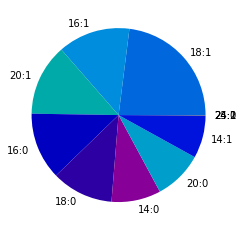

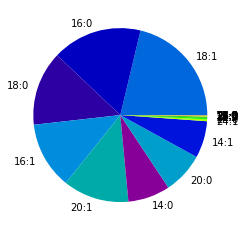

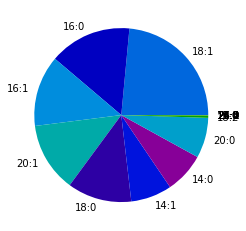

In [19]:
def generate_color_dict(index_values):
     
    num_colors = len(index_values)
    colors = plt.cm.nipy_spectral(np.linspace(0.1,.9,num_colors))
    
    color_dict = {}
    for i, value in enumerate(index_values):
        
        rgba_color = colors[i]
        color_dict[value] = rgba_color
    
    return color_dict

# Sample index
index = ['14:0', '18:0', '16:0', '14:1', '18:1', '16:1', '20:0', '20:1',
         '15:0','17:0','18:2','19:0','22:0', '23:0', '24:0', '24:1', 
         '24:2', '24:3', '25:0', '25:1', '26:0', '26:1', '26:2']

# Generate the color dictionary
color_dict = generate_color_dict(index[::])

# Print the color dictionary
print(color_dict)

# Make pie charts of side chain
for col in slimeR2.columns:
    if 'mean' in col:
        fig = plt.figure()
        data = slimeR2[col][slimeR2[col]>0].sort_values(ascending=False)
        #cc = plt.cycler("color", plt.cm.CMRmap(np.linspace(0.1,.99,len(mean_s))))
        ax = fig.add_subplot()
        ax.pie(data,labels=data.index,colors=[color_dict[item] for item in data.index])
        #plt.show()

# Combing head and side chain dfs for SLIMEr 

In [120]:
#slimeR_2_a = slimeR_2_a.drop(columns='reaction')
slimeR_2_a = slimeR_2_a/slimeR_2_a.sum()
slimeR_2_a['reaction'] =['2a']*len(slimeR_2_a)

In [121]:
slimeR_pseudo = slimeR_2_a.T.join(sidechains.T)
slimeR_pseudo.T

,mean_Ring,mean_Trophozoite,mean_Schizont,reaction
CE,0.0,0.000147,0.0,2a
DAG,0.06707,0.086751,0.108538,2a
FreeChol,0.0,0.117501,0.044882,2a
LPC,0.0,0.0,0.0,2a
PC,0.423594,0.440899,0.518696,2a
...,...,...,...,...
38:5,0.0,0.001489,0.0,2b
40:5,0.0,0.00297,0.000506,2b
40:6,0.004633,0.004116,0.001511,2b
54:6,0.013541,0.007004,0.001179,2b


In [21]:
'''pupative_imported = permutation[permutation.index.isin(outlayers)]
slimeR_imported = pupative_imported
print(slimeR_imported.columns)
slimeR_imported = slimeR_imported.T-slimeR_imported['mean_RBC'].values
slimeR_imported = slimeR_imported.drop(index='mean_RBC')
slimeR_imported = slimeR_imported.T
slimeR_imported['reaction'] = ['T']*len(slimeR_imported)'''

Index(['mean_RBC', 'mean_Ring ', 'mean_Trophozoite ', 'mean_Schizont '], dtype='object')


In [122]:
#slimeR_pseudo_all = slimeR_pseudo.join(slimeR_imported.T)
#slimeR_pseudo_all = slimeR_pseudo_all.T
slimeR_pseudo.T.to_csv('slimeR_pseudo_all_percent.tsv',sep='\t')

# SLIMEr Lipids to produce

In [23]:
slimeR_metabolites_df = pd.DataFrame(name_dict, index=['mean_Ring ','mean_Trophozoite ','mean_Schizont ']).T
#slimeR_metabolites_df['slimer']= slimeR_metabolites_df.index.map(SLIMEr_writer) 
slimeR_metabolites_df['reaction']=['p']*len(slimeR_metabolites_df)
slimeR_metabolites_df

,mean_Ring,mean_Trophozoite,mean_Schizont,reaction
PC (32:0) 14:0_18:0,4.365000,35.267778,66.428333,p
PC (32:0) 16:0_16:0,4.365000,35.267778,66.428333,p
PC (32:1) 14:0_18:1,0.306667,3.490370,16.222222,p
PC (32:1) 14:1_18:0,0.306667,3.490370,16.222222,p
PC (32:1) 16:1_16:0,0.306667,3.490370,16.222222,p
...,...,...,...,...
TAG (54:2) 14:0_20:1_20:1,NaN,NaN,2.363333,p
TAG (54:2) 14:1_20:1_20:0,NaN,NaN,2.363333,p
TAG (54:3) 16:1_18:1_20:1,NaN,NaN,3.452222,p
TAG (54:3) 18:1_18:1_18:1,NaN,NaN,3.452222,p


In [24]:
# Search alex original data for correctly depicted PLs
alex_string1 = [s for s in strings if re.search(r'\([\w\s:]+\)', s) and any(int(val) > 26 for val in re.findall(r'\b\d+\b', s))]
alex_string2  = [s for s in strings if re.search( r'(?:CE|SM|Cer) \d+', s)]
alex_strings = alex_string1+alex_string2
alex_right_df = df_alex[df_alex.index.isin(alex_strings)]
alex_right_df = alex_right_df[['mean_RBC','mean_Ring ','mean_Trophozoite ','mean_Schizont ']]
alex_right_df = alex_right_df.T-alex_right_df['mean_RBC'].values
alex_right_df = alex_right_df.drop(index='mean_RBC').T
alex_right_df['reaction'] = ['p']*len(alex_right_df)
# Pattern finder so that PLs with side chain that has more than 1 unsaturation get flagged as transported
slimer_str = alex_right_df.index
pattern = r'(?:.*?:(?P<second_instance>[2-9])){2}'
to_change_reactions = [string for string in slimer_str if re.search(pattern, string) if not 'TAG' in string]
alex_right_df.loc[alex_right_df.index.isin(to_change_reactions),'reaction']='T'
# Joining of the different df for the metabolites
slimeR_met = alex_right_df.T.join(slimeR_imported.T)
slimeR_meta_1_df = slimeR_metabolites_df.T.join(slimeR_met)
slimeR_meta_1_df = slimeR_meta_1_df.T.sort_index()
slimeR_meta_1_df

,mean_Ring,mean_Trophozoite,mean_Schizont,reaction
CE 16:0,-3.046667,0.21,-2.863333,p
CE 16:1,-2.04,-1.593333,-3.103333,p
CE 18:1,-6.953333,-5.32,-11.016667,p
CE 18:2,-24.6,-18.793333,-36.313333,p
CE 18:3,-4.283333,-2.843333,-5.7,p
...,...,...,...,...
TAG (54:3) 14:1_20:1_20:1,NaN,NaN,3.452222,p
TAG (54:3) 16:1_18:1_20:1,NaN,NaN,3.452222,p
TAG (54:3) 18:1_18:1_18:1,NaN,NaN,3.452222,p
TAG 54:6,4.393333,15.365556,6.42,T


In [25]:
#slimeR_meta_1_df.to_csv('slimeR_PLs.csv',sep=',')

# Compare Hsiao against Alex

In [26]:
hsiao = pd.read_csv('/home/karnet/Downloads/Hsiao1991/PL_all.csv',skiprows=0)
hsiao['Parasite'] = hsiao['Purified parasites'].apply(lambda x: float(x.split(' + ')[0]))
hsiao['uRBC'] = hsiao['Uninfected erythrocytes'].apply(lambda x: float(x.split(' ')[0]))
hsiao['IEPM'] = hsiao['IEPM'].apply(lambda x: float(x.split(' ')[0]))

hsiao['Unnamed: 0'] = hsiao['Unnamed: 0'].apply(lambda x : x[1:])
hsiao.set_index('Unnamed: 0', inplace=True)
hsiao

,Uninfected erythrocytes,IEPM,Purified parasites,Parasite,uRBC
Unnamed: 0,,,,,
14:0,0.31 + 0.01,1.46,0.87 + 0.17,0.87,0.31
16:0,22.68 + 4.43,31.15,32.32 + 0.67,32.32,22.68
16:1,0.80 + 0.22,1.87,2.14 + 0.39,2.14,0.80
17:0,0.21 + 0.06,0.46,0.42 + 0.07,0.42,0.21
16:2,0.96 + 0.69,0.67,0.64 + 0.33,0.64,0.96
18:0,14.20 + 1.29,13.87,13.27 + 3.00,13.27,14.20
18:1,14.18 + 0.35,24.60,24.82 + 1.72,24.82,14.18
18:2,12.67 + 0.76,10.10,12.33 + 0.64,12.33,12.67
20:0,0.10 + 0.02,0.15,0.69 + 0.69,0.69,0.10


In [27]:
df_stoich = pd.DataFrame(stoich_side_chain_lst).T
df_stoich = df_stoich.fillna(0)
df_stoich = df_stoich.apply(lambda x: x/(sum(x))*100)
print(df_stoich.to_markdown())

|      |           0 |           1 |            2 |
|:-----|------------:|------------:|-------------:|
| 14:0 |  9.17407    |  7.83222    |  7.51462     |
| 18:0 | 11.4766     | 13.8463     | 11.9418      |
| 16:0 | 12.479      | 16.6689     | 15.2947      |
| 14:1 |  7.98097    |  6.84995    |  7.63047     |
| 18:1 | 23.0045     | 21.2619     | 23.5024      |
| 16:1 | 13.424      | 12.4598     | 13.2013      |
| 20:0 |  9.10173    |  7.6948     |  7.50166     |
| 20:1 | 13.3156     | 12.2563     | 12.906       |
| 24:1 |  0.0117813  |  0.346193   |  0.00880193  |
| 24:2 |  0.0294533  |  0.140622   |  0.0154372   |
| 25:0 |  0.00235627 |  0.0298524  |  0.0066353   |
| 15:0 |  0          |  0.00113213 |  0           |
| 17:0 |  0          |  0.00804406 |  0.0009479   |
| 18:2 |  0          |  0.193057   |  0.457362    |
| 22:0 |  0          |  0.00923577 |  0.00169268  |
| 23:0 |  0          |  0.0203783  |  0           |
| 24:0 |  0          |  0.309845   |  0.00480721  |
| 24:3 |  0 

In [28]:
df_merge = hsiao.merge(df_stoich, left_index=True, right_index=True)
sum_row = df_merge.sum()
sum_row.name = 'Sum'
df_merge = df_merge.append(sum_row)
df_merge = df_merge.drop(columns=['Uninfected erythrocytes','Purified parasites'])
data_df = df_merge

In [29]:
def SLIMEr_writer(name:str) -> str:
    edukt = name
    to_slice = name.find('(')
    if to_slice!=-1:
        name = name[:to_slice-1] + name[to_slice+6:]
    name = name.replace('_', ' ')
    name = name.replace(' ',' + 1 ')
    product = '1 '+ name
    if 'Cer' or 'SM' in name:
        product = product + ' + 1 18:1'
    return edukt +  ' -> ' + product

slimeR_meta_1_df.index.map(SLIMEr_writer)


Index(['CE 16:0 -> 1 CE + 1 16:0 + 1 18:1',
       'CE 16:1 -> 1 CE + 1 16:1 + 1 18:1',
       'CE 18:1 -> 1 CE + 1 18:1 + 1 18:1',
       'CE 18:2 -> 1 CE + 1 18:2 + 1 18:1',
       'CE 18:3 -> 1 CE + 1 18:3 + 1 18:1',
       'CE 20:4 -> 1 CE + 1 20:4 + 1 18:1',
       'CE 20:5 -> 1 CE + 1 20:5 + 1 18:1',
       'Cer 16:0 -> 1 Cer + 1 16:0 + 1 18:1',
       'Cer 18:0 -> 1 Cer + 1 18:0 + 1 18:1',
       'Cer 19:0 -> 1 Cer + 1 19:0 + 1 18:1',
       ...
       'TAG (54:2) 14:1_20:1_20:0 -> 1 TAG + 1 14:1 + 1 20:1 + 1 20:0 + 1 18:1',
       'TAG (54:2) 16:0_18:1_20:1 -> 1 TAG + 1 16:0 + 1 18:1 + 1 20:1 + 1 18:1',
       'TAG (54:2) 16:1_18:0_20:1 -> 1 TAG + 1 16:1 + 1 18:0 + 1 20:1 + 1 18:1',
       'TAG (54:2) 16:1_18:1_20:0 -> 1 TAG + 1 16:1 + 1 18:1 + 1 20:0 + 1 18:1',
       'TAG (54:2) 18:1_18:1_18:0 -> 1 TAG + 1 18:1 + 1 18:1 + 1 18:0 + 1 18:1',
       'TAG (54:3) 14:1_20:1_20:1 -> 1 TAG + 1 14:1 + 1 20:1 + 1 20:1 + 1 18:1',
       'TAG (54:3) 16:1_18:1_20:1 -> 1 TAG + 1 16:1 + 1 1

In [30]:
# Dictionary to store results
results = {}

# Fetch BiGG IDs and names
for metabolite in slimeR_meta_1_df.index:
    meta_lst = metabolite.split(' ')
    better_name = meta_lst[0]
    i=1
    while meta_lst[i:]:
        if meta_lst[i].startswith('('):
            i+=1
            continue
        better_name = better_name.lower()+meta_lst[i].replace(':','').replace('_','')
        i+=1
    results[metabolite]=better_name
results

{'CE 16:0': 'ce160',
 'CE 16:1': 'ce161',
 'CE 18:1': 'ce181',
 'CE 18:2': 'ce182',
 'CE 18:3': 'ce183',
 'CE 20:4': 'ce204',
 'CE 20:5': 'ce205',
 'Cer 16:0': 'cer160',
 'Cer 18:0': 'cer180',
 'Cer 19:0': 'cer190',
 'Cer 22:0': 'cer220',
 'Cer 24:0': 'cer240',
 'Cer 24:1': 'cer241',
 'Cer 24:2': 'cer242',
 'DAG (32:0) 16:0_16:0': 'dag160160',
 'DAG (34:0) 16:0_18:0': 'dag160180',
 'DAG (34:1) 16:0_18:1': 'dag160181',
 'DAG (36:1) 18:0_18:1': 'dag180181',
 'DAG (36:2) 18:1_18:1': 'dag181181',
 'DHSM 16:0': 'dhsm160',
 'DHSM 17:0': 'dhsm170',
 'DHSM 18:0': 'dhsm180',
 'DHSM 19:0': 'dhsm190',
 'DHSM 20:0': 'dhsm200',
 'DHSM 22:0': 'dhsm220',
 'DHSM 24:0': 'dhsm240',
 'DHSM 25:0': 'dhsm250',
 'PC (32:0) 14:0_18:0': 'pc140180',
 'PC (32:0) 16:0_16:0': 'pc160160',
 'PC (32:1) 14:0_18:1': 'pc140181',
 'PC (32:1) 14:1_18:0': 'pc141180',
 'PC (32:1) 16:1_16:0': 'pc161160',
 'PC (34:0) 14:0_20:0': 'pc140200',
 'PC (34:0) 16:0_18:0': 'pc160180',
 'PC (34:1) 14:0_20:1': 'pc140201',
 'PC (34:1) 14

In [31]:
df = pd.DataFrame(results.items(), columns=['Metabolite', 'Name'])
df.to_csv('blub')

## Statistical tests dataframe 

In [32]:
from scipy.stats import chi2_contingency

# Create a sample DataFrame
data = {'Category': ['A', 'B', 'C', 'D'],
        'Group1': [25, 30, 15, 30],
        'Group2': [20, 40, 25, 15]}
percentage_df = pd.DataFrame(data)
percentage_df.set_index('Category', inplace=True)

# Set 'Category' as the index
# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(percentage_df)

# Print the results
print("Chi-Square:", chi2)
print("P-value:", p)


Chi-Square: 9.484126984126984
P-value: 0.023500823599378873


In [33]:
data_df = data_df.drop('Sum')

In [34]:

# Select all columns except 'uRBC'
columns_to_test = data_df.columns.difference(['uRBC'])

# Create a list to store the results
chi_square_results = []

# Iterate over the selected columns
for column in columns_to_test:
    contingency_table = data_df[['uRBC',column]]
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results.append({'Column': column, 'Chi-Square': chi2, 'P-value': p})

# Convert the results to a DataFrame
chi_square_results_df = pd.DataFrame(chi_square_results)

# Print the results or perform further analysis
chi_square_results_df

,Column,Chi-Square,P-value
0,0,53.564147,5.848855e-08
1,1,44.671797,2.492136e-06
2,2,47.311526,8.287061e-07
3,IEPM,6.332676,7.865819e-01
4,Parasite,7.427125,6.845995e-01
